# Skin Cancer Classification
In this project, we aim to classify skin cancer types using Convolutional Neural Networks with Keras and TensorFlow backend. We are working with the HAM10000 (Humans Against Machine 10000) dataset, which includes dermatoscopic images of various skin lesions. This is a challenging task as it requires a nuanced approach due to the fine-grained variability in the appearance of these lesions affecting the accuracy of our classifications.

It has 7 different classes of skin cancer which are listed below :<br>
**1. Melanocytic nevi <br>**
**2. Melanoma <br>**
**3. Benign keratosis-like lesions <br>**
**4. Basal cell carcinoma <br>**
**5. Actinic keratoses <br>**
**6. Vascular lesions <br>**
**7. Dermatofibroma<br>**

<img src="https://image.ibb.co/n8PBkL/cover.png">

## Step 1: Setup and Data Acquisition
Here we set up our environment and download the dataset necessary for our project. This includes installing the Kaggle API, setting up configurations, and downloading the Skin Cancer MNIST: HAM10000 dataset.

In [ ]:
import os
import cv2
import shutil
import random
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image
import tensorflow as tf
from matplotlib import pyplot as plt
from keras.utils import to_categorical
from tensorflow.keras import Sequential
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Flatten, Dense, Dropout, BatchNormalization
from keras.applications import ResNet50
from keras.utils import plot_model

# Suppressing warnings
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Install the Kaggle command-line tool
!pip install -q kaggle

In [ ]:
# Upload Kaggle API Key to Colab
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ngtminh","key":"2e9aa66256ead50cdbf258d78be73145"}'}

In [ ]:
# Set Up Kaggle Configuration
!mkdir ~/.kaggle # Creates a '.kaggle' directory in home directory
!cp kaggle.json  ~/.kaggle/ # Copy the Kaggle API key to the '.kaggle' in home directory
!chmod 600 ~/.kaggle/kaggle.json # Set the file permissions for the Kaggle API key

In [ ]:
# Download the Dataset
!kaggle datasets download -d farjanakabirsamanta/skin-cancer-dataset

 99% 2.56G/2.58G [00:27<00:00, 177MB/s]
100% 2.58G/2.58G [00:27<00:00, 101MB/s]


In [ ]:
# Extract Dataset
!mkdir skin_cancer # Create a new directory named 'skin_cancer'
!unzip skin-cancer-dataset.zip -d skin_cancer # Unzips the contents of the dataset zip file into directory created above

In [ ]:
# Loading the metadata
meta_data = pd.read_csv("/content/skin_cancer/HAM10000_metadata.csv")
meta_data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


## Step 2: Data Cleaning and Exploration
Here, we clean and explore the dataset.

In [ ]:
# Check for null values
meta_data.isnull().sum()

lesion_id        0
image_id         0
dx               0
dx_type          0
age             57
sex              0
localization     0
dtype: int64

In [ ]:
# There are null values in age, thus we will fill the null values by their mean
meta_data['age'].fillna(meta_data['age'].mean(), inplace=True)

# Confirm no more null values
meta_data.isnull().sum()

lesion_id       0
image_id        0
dx              0
dx_type         0
age             0
sex             0
localization    0
dtype: int64

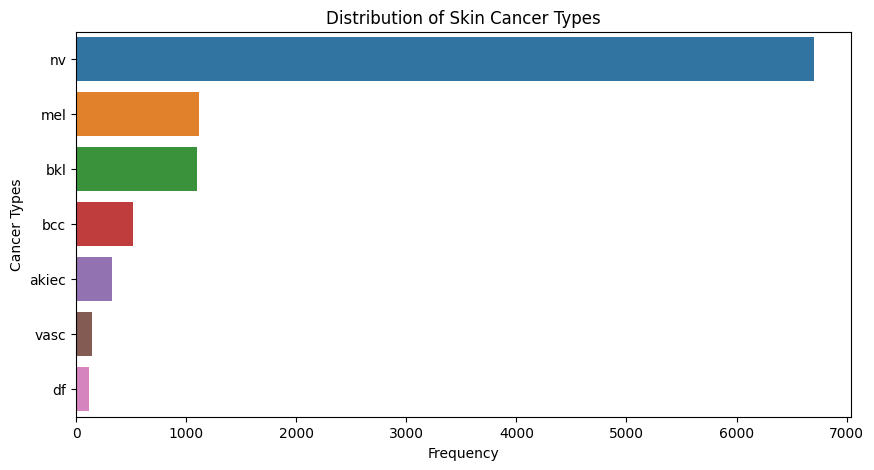

In [ ]:
# Distribution of classes
# Melanocytic nevi has very large number of data compared to other data
plt.figure(figsize=(10, 5))
sns.countplot(y=meta_data['dx'], order = meta_data['dx'].value_counts().index)
plt.title('Distribution of Skin Cancer Types')
plt.xlabel('Frequency')
plt.ylabel('Cancer Types')
plt.show()

<Axes: >

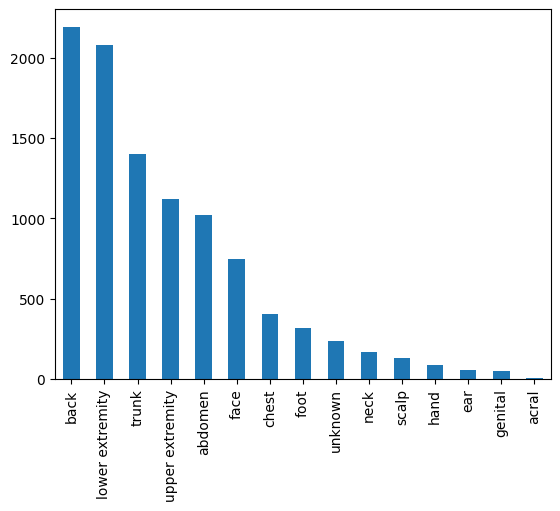

In [ ]:
# The back, lower extremity and trunk areas are the most compromised areas for skin cancer
meta_data['localization'].value_counts().plot(kind='bar')

<Axes: >

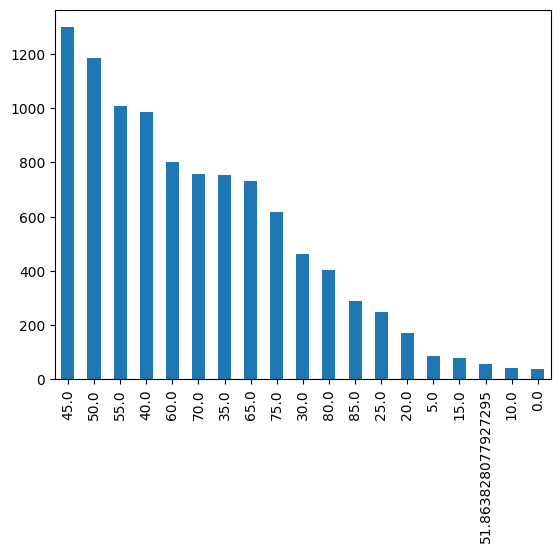

In [ ]:
# Visualise the agewise distribution of skin cancer types
meta_data['age'].value_counts().plot(kind='bar')

<Axes: >

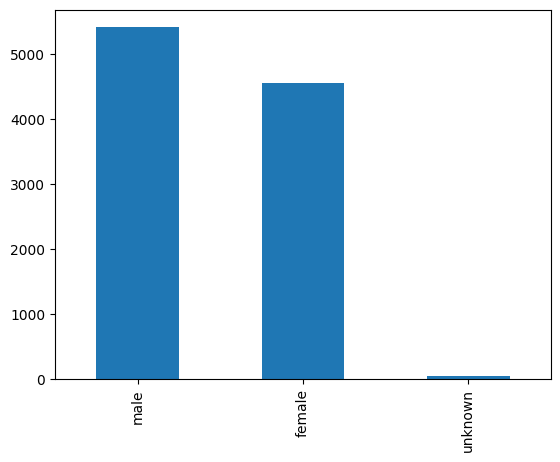

In [ ]:
# Visualise the genderwise distribution of skin cancer types
meta_data['sex'].value_counts().plot(kind='bar')


# Step 3: Data preprocessing

### 1.Data sorting

In [ ]:
# Displaying unique cancer types
print("Unique Cancer types represented in data.")
print(meta_data.dx.unique(),"\n")

# Handling categorical data
encoder = LabelEncoder()
meta_data["dx_label"] = encoder.fit_transform(meta_data["dx"])

# Display of labels and their integer encoding
print("Cancer types and their integer encoding")
print(encoder.classes_)
print(encoder.transform(encoder.classes_))

Unique Cancer types represented in data.
['bkl' 'nv' 'df' 'mel' 'vasc' 'bcc' 'akiec'] 

Cancer types and their integer encoding
['akiec' 'bcc' 'bkl' 'df' 'mel' 'nv' 'vasc']
[0 1 2 3 4 5 6]


In [ ]:
# Sorting images into appropriate directories in order
# to facilitate real-time data augmentation while training.

# Using the cancer type label for directory creation.
dir_names = encoder.transform(encoder.classes_)

# Data Sorting process.
images_dir = r"/content/skin_cancer/Skin Cancer/Skin Cancer"
train_images_dir = r"/kaggle/working/train/"


def create_dirs(dir_path:str, dir_names:list):
    """
    This function creates directories within specified directory path
    with the provided list of directory names.

    Inputs
        dir_path:str - The path to which the new directories will reside in.
        dir_names:list - List name(s) of directories to be created.
    """
    # Looping through to create directories in new location.
    for dir_name in dir_names:
        try:
            os.makedirs(os.path.join(dir_path, str(dir_name)))
        except FileExistsError:
            continue


# Creating new directories.
create_dirs(train_images_dir, dir_names)

# Looping through each image in previous folder and
# assigning them to the appropriate folder
for image in os.scandir(images_dir):
    try:
        # attempting to rename image (moving to new dir).
        img_name = image.name.split(".")[0]
        img_cancer_type = str(meta_data.dx_label[meta_data.image_id == img_name].item()) # Retrieving the dx_label for image.
        shutil.copy(os.path.join(images_dir, image.name), os.path.join(train_images_dir, img_cancer_type, image.name))
    except Exception as e:
        print(e)

### 2. Creating validation set

In [ ]:
test_images_dir = r"/kaggle/working/validation/"
inds = [] # list to contain directory names of each image.
twenty_percent_content = {} # Dictionary containing cancer type and the value that is 5% of total number of that type of cancer images.

# Finding out how many images of each cancer type exist
for dir_name in os.scandir(train_images_dir): # Iterating over all train images folders.
    for cancer_img in os.scandir(dir_name): # Iterating over all images in all folders.
        inds.append(cancer_img.path.split("/")[4]) # Appending each images directro number to inds for counting & sorting purpose.


# Calculating number of specific type images &
# Calculating what 20% of each image type will be.
for directory in dir_names:
    total_amt = inds.count(str(directory))
    c_type = encoder.inverse_transform([int(directory)])[0]
    print(f"There are {total_amt} images of {c_type} cancer.")
    print(f"20% of {c_type} cancer images is: {round(total_amt * 0.20, 0)}\n")
    twenty_percent_content[str(directory)] = round(total_amt * 0.20, 0)


# Creating and populating validation set directory
create_dirs(test_images_dir, dir_names)


# Moving 20% of each type into its respective validation folder.
# Looping through each sub directory
for sub_dir in os.scandir(train_images_dir):
    # Getting all images in current subdir
    images_paths = [image.path for image in os.scandir(sub_dir)]
    # Extracting 20% of images from each directory.
    for image_path in images_paths[: int(twenty_percent_content[str(sub_dir.name)])]:
        # Getting category for individual images
        image_category = image_path.split("/")[4]
        # creating new image path and moving old image to new destination.
        shutil.move(image_path, os.path.join(test_images_dir, image_category, image_path.split("/")[-1]))

There are 311 images of akiec cancer.
20% of akiec cancer images is: 62.0

There are 488 images of bcc cancer.
20% of bcc cancer images is: 98.0

There are 1044 images of bkl cancer.
20% of bkl cancer images is: 209.0

There are 109 images of df cancer.
20% of df cancer images is: 22.0

There are 1057 images of mel cancer.
20% of mel cancer images is: 211.0

There are 6370 images of nv cancer.
20% of nv cancer images is: 1274.0

There are 135 images of vasc cancer.
20% of vasc cancer images is: 27.0



### 3. Data visualization
Visualize what the different types of skin cancer looks like

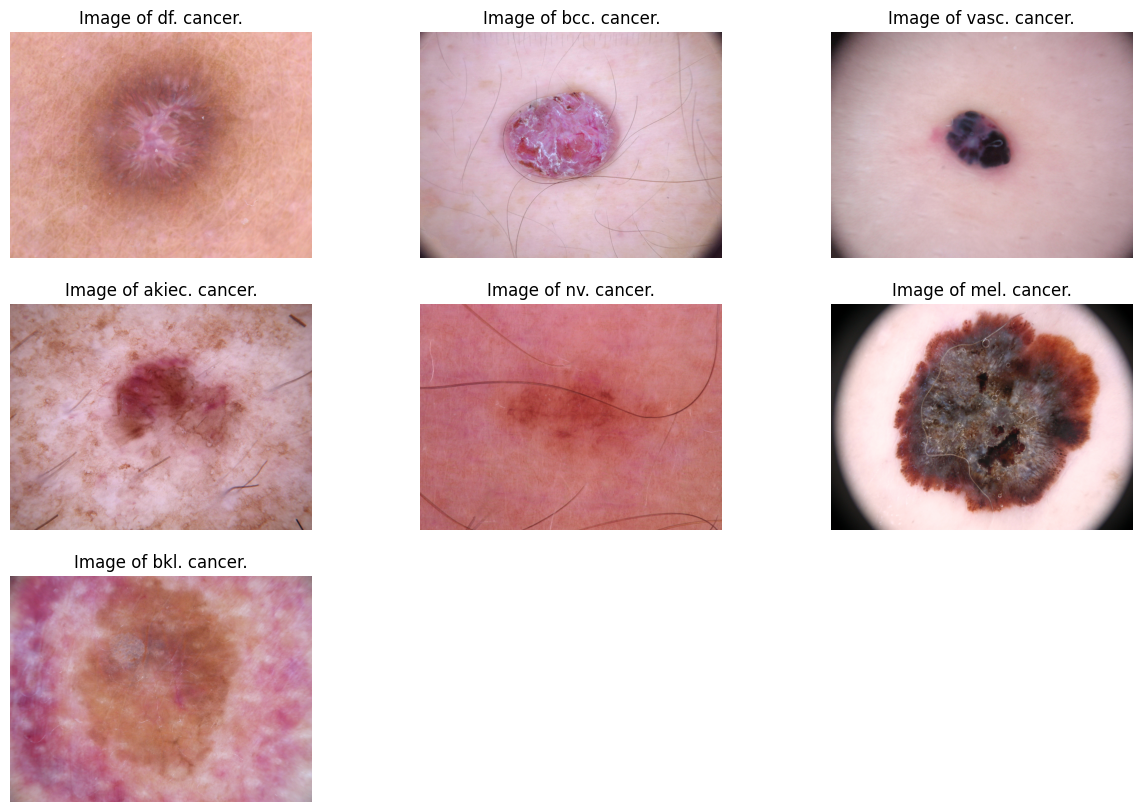

In [ ]:
top_n = 20 # Variable for top-n random images to select from.
image_sample = [] # List containing array of images.
image_sample_category = [] # List containing image type

for sub_dir in os.scandir(train_images_dir):
    # Getting all images in current subdir
    images_paths = [image.path for image in os.scandir(sub_dir)]
    current_dir_img_paths = [] # List of top n images from current sub-dir.
    # Extracting random image from each directory.
    for image_path in images_paths[:top_n]:
        current_dir_img_paths.append(image_path) # Appending images from current sub-dir to orary list
        image = random.choice(current_dir_img_paths) # Selecting random image from current images.
        image = cv2.imread(image)[:,:,::-1] # Reading in image and arranging colors.
    image_sample_category.append((encoder.inverse_transform([int(image_path.split("/")[4])])[0])) # Appending image category name to array.
    image_sample.append(image) # Appending image array to list.


plt.figure(figsize = (15,10))
for num in range(0, len(image_sample)):
    plt.subplot(3, 3 ,num + 1)
    plt.axis(False)
    plt.title(f"Image of {image_sample_category[num]}. cancer.")
    plt.imshow(image_sample[num]);

### 4. Data augmentation

In [ ]:
img_size = 250 # Augmented image size.
batch_size = 32

generator = ImageDataGenerator(zoom_range = 0.3,
                               rotation_range = 90,
                               horizontal_flip = True,
                               vertical_flip = True,
                               validation_split = 0.1,)

# Augmented training set
augmented_train_data = generator.flow_from_directory(
                            train_images_dir,
                            target_size = (img_size, img_size),
                            batch_size = batch_size,
                            subset = "training")

# Un-augmented test set
unaugmented_validation_data = generator.flow_from_directory(
                            train_images_dir,
                            target_size = (img_size, img_size),
                            batch_size = 32,
                            subset = "validation")

# Un-augmented dev set.
unaugmented_test_data = image_dataset_from_directory(
                            test_images_dir,
                            image_size = (img_size, img_size),
                            batch_size = batch_size)

Found 6854 images belonging to 7 classes.
Found 757 images belonging to 7 classes.
Found 2404 files belonging to 7 classes.


## Step 4: Model training
In this section, we train our CNN model with the sequential model architecture, compile the model, and fit it to our training data.


In [ ]:
# Load pre-trained ResNet50 model without the top (classification) layer
resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(250, 250, 3))

# Freeze the weights of the ResNet50 layers so that they are not trained
for layer in resnet_model.layers:
    layer.trainable = False

# Defining model architecture
model = Sequential()

# Add the ResNet50 model as the first layer
model.add(resnet_model)

# Layer one
model.add(BatchNormalization())
model.add(Conv2D(64, kernel_size = (3,3), input_shape= (250, 250, 3)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size = (2,2)))

# Layer two
model.add(Conv2D(32, kernel_size = (3,3)))
model.add(Activation("relu"))

# Layer three
model.add(Flatten())
model.add(Dense(64))
model.add(Activation("relu"))

# Layer four
model.add(Flatten())
model.add(Dense(32))
model.add(Activation("relu"))

# Layer five
model.add(Dense(7))
model.add(Activation("softmax"))

# Callbacks for improved training
callbacks = [
    tf.keras.callbacks.ModelCheckpoint('best_model.h5', save_best_only=True),
    tf.keras.callbacks.EarlyStopping(patience=5),
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=3)
]

# Compile the model
model.compile(
    loss = "categorical_crossentropy",
    optimizer = "adam",
    metrics = ["accuracy"],
)

# Train the model using the `fit` method
history = model.fit(
    augmented_train_data,
    validation_data=unaugmented_validation_data,
    epochs=15,
    verbose = 1,
    callbacks=callbacks
)

Epoch 1/15
215/215 [==============================] - 177s 802ms/step - loss: 0.9253 - accuracy: 0.6816 - val_loss: 0.7816 - val_accuracy: 0.7226 - lr: 0.0010
Epoch 2/15
215/215 [==============================] - 175s 811ms/step - loss: 0.7701 - accuracy: 0.7207 - val_loss: 0.7089 - val_accuracy: 0.7398 - lr: 0.0010
Epoch 3/15
215/215 [==============================] - 183s 850ms/step - loss: 0.7066 - accuracy: 0.7451 - val_loss: 0.6754 - val_accuracy: 0.7556 - lr: 0.0010
Epoch 4/15
215/215 [==============================] - 184s 854ms/step - loss: 0.6678 - accuracy: 0.7617 - val_loss: 0.6868 - val_accuracy: 0.7569 - lr: 0.0010
Epoch 5/15
215/215 [==============================] - 183s 851ms/step - loss: 0.6281 - accuracy: 0.7706 - val_loss: 0.6378 - val_accuracy: 0.7688 - lr: 0.0010
Epoch 6/15
215/215 [==============================] - 184s 856ms/step - loss: 0.5962 - accuracy: 0.7854 - val_loss: 0.6568 - val_accuracy: 0.7886 - lr: 0.0010
Epoch 7/15
215/215 [==========================

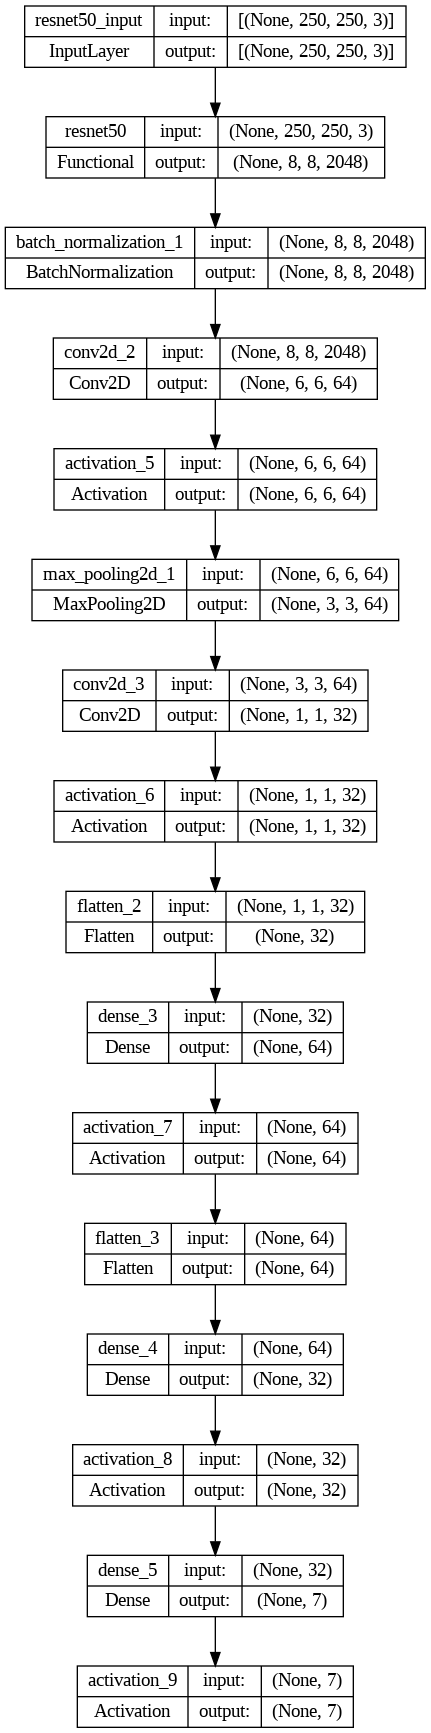

In [ ]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

## Step 5: Model Evaluation
Finally, we evaluate our model's performance using various metrics like accuracy, loss, and a confusion matrix. This will help us understand how well our model is performing and where it can be improved.

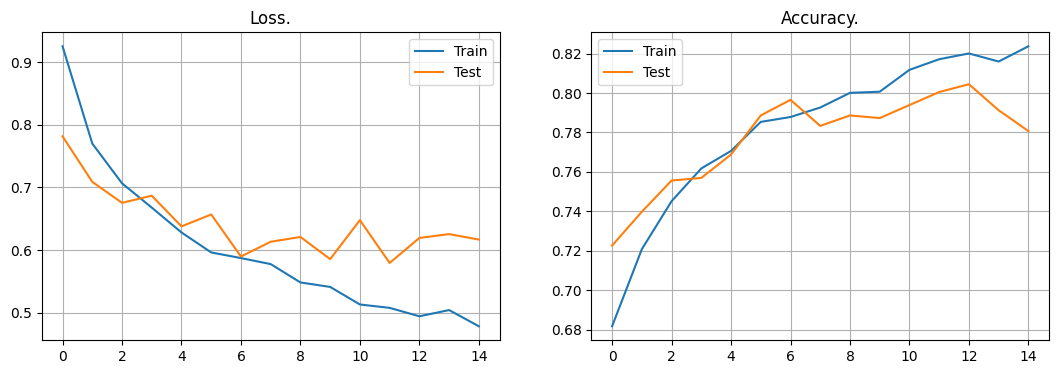

In [ ]:
# Extracting metrics
metrics = history.history

train_loss = metrics["loss"]
train_accuracy = metrics["accuracy"]

test_loss = metrics["val_loss"]
test_accuracy = metrics["val_accuracy"]

# Visualizing metrics
plt.figure(figsize = (13,4))
plt.subplot(1,2,1)
plt.title("Loss.")
plt.plot(train_loss, label = "Train");
plt.plot(test_loss, label = "Test");
plt.grid(True)
plt.legend(loc = "best");

plt.subplot(1,2,2)
plt.title("Accuracy.")
plt.plot(train_accuracy, label = "Train");
plt.plot(test_accuracy, label = "Test");
plt.grid(True)
plt.legend(loc = "best");

In [ ]:
result = model.predict(unaugmented_test_data)

76/76 [==============================] - 9s 113ms/step


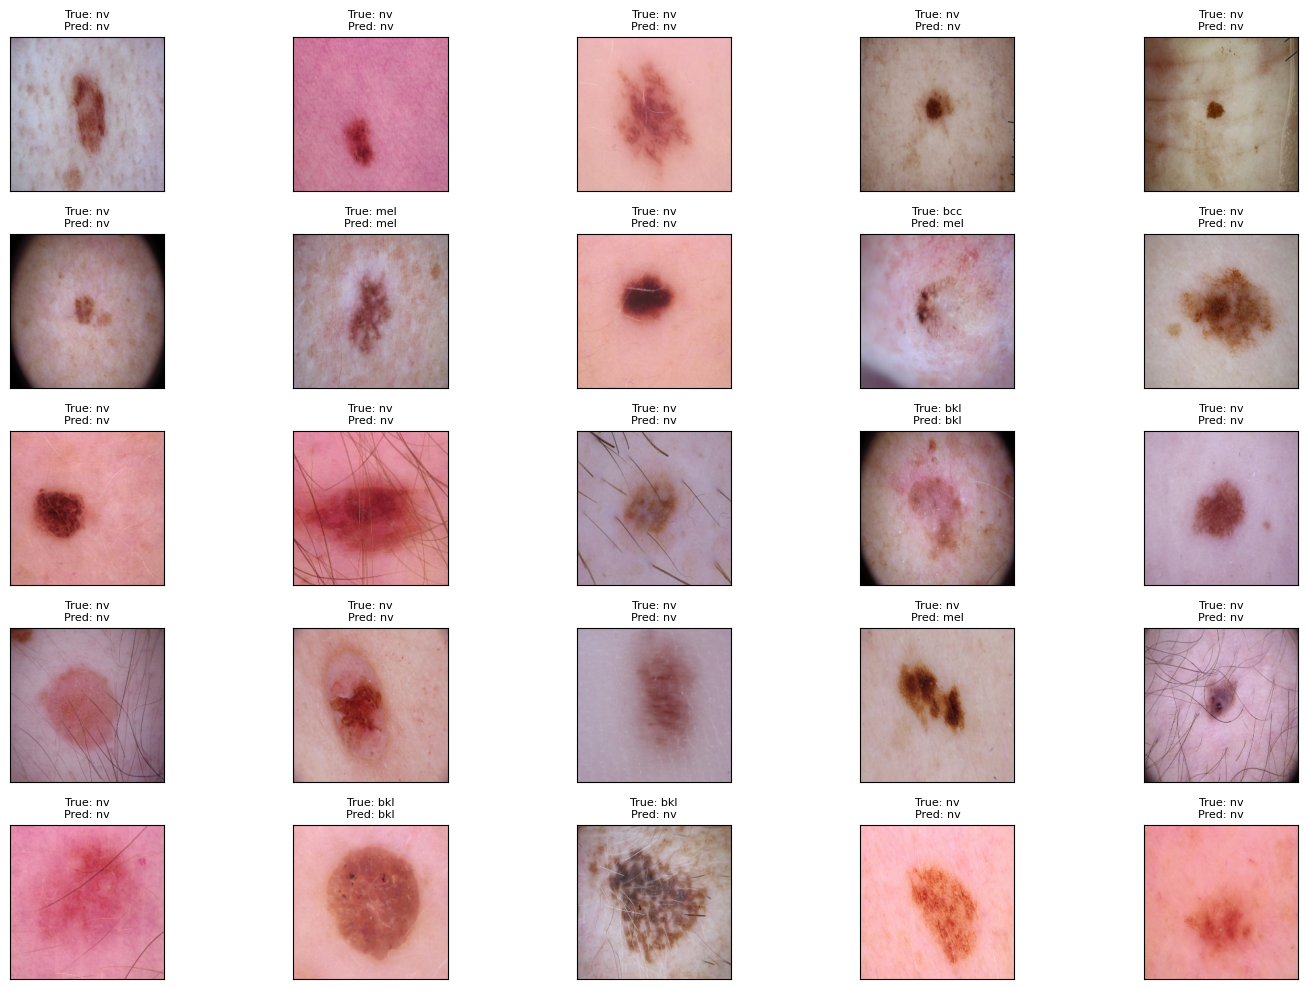

In [ ]:
# Initialize empty lists to store test data and true labels
X_test = []
true_class = []
for images, labels in unaugmented_test_data.take(-1):  # take(-1) to take all batches
    for i in range(images.shape[0]):
        X_test.append(images[i].numpy())  # Convert tensor to numpy array
        true_class.append(labels[i].numpy())  # Convert labels to numpy array

# Convert lists to numpy arrays for easier indexing later
X_test = np.array(X_test)
true_class = np.array(true_class)

# Predict on test data
result = model.predict(X_test)
predicted_class = [predicted_label.argmax() for predicted_label in result]

label_dict = label_dict = {
    0: 'akiec',
    1: 'bcc',
    2: 'bkl',
    3: 'df',
    4: 'mel',
    5: 'nv',
    6: 'vasc'
}

def plot_images(images, true_labels, predicted_labels):
    plt.figure(figsize=(15, 10))
    for i in range(len(images)):
        plt.subplot(5, 5, i+1)
        img = images[i]
        if img.max() > 1:
            img = img / 255.0  # Normalize
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])
        true_label = label_dict[true_labels[i]]
        predicted_label = label_dict[predicted_labels[i]]
        plt.title(f"True: {true_label}\nPred: {predicted_label}", fontsize=8)
        if i == 24:  # Only display the first 25 images
            break
    plt.tight_layout()
    plt.show()

# Plot test images along with the true and predicted labels
plot_images(X_test, true_class, predicted_class)


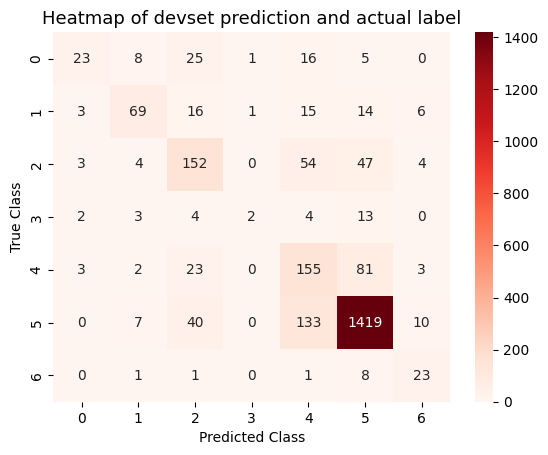

In [ ]:
# Calculating confusion matrix
plt.title("Heatmap of devset prediction and actual label", fontsize = 13)
cm = confusion_matrix(true_class, predicted_class)
sns.heatmap(cm, cmap = "Reds", annot = True, fmt = "d");
plt.ylabel("True Class");
plt.xlabel("Predicted Class");

In [ ]:
# Understanding classification power of model on each class
report = classification_report(true_class, predicted_class)
print(report)

              precision    recall  f1-score   support

           0       0.68      0.29      0.41        78
           1       0.73      0.56      0.63       124
           2       0.58      0.58      0.58       264
           3       0.50      0.07      0.12        28
           4       0.41      0.58      0.48       267
           5       0.89      0.88      0.89      1609
           6       0.50      0.68      0.58        34

    accuracy                           0.77      2404
   macro avg       0.61      0.52      0.53      2404
weighted avg       0.78      0.77      0.77      2404

